In [1]:
# Data
import numpy as np
from tensorflow.examples.tutorials.mnist import input_data
import impl.layer as l

# Dataset preparation and pre-processing
mnist = input_data.read_data_sets('data/MNIST_data/', one_hot=False)

X_train, y_train = mnist.train.images, mnist.train.labels
X_val, y_val = mnist.validation.images, mnist.validation.labels
X_test, y_test = mnist.test.images, mnist.test.labels

Extracting data/MNIST_data/train-images-idx3-ubyte.gz
Extracting data/MNIST_data/train-labels-idx1-ubyte.gz
Extracting data/MNIST_data/t10k-images-idx3-ubyte.gz
Extracting data/MNIST_data/t10k-labels-idx1-ubyte.gz


In [2]:
# Pre-processing: normalizing
def normalize(X):
    # max scale for images 255= 2**8= 8 bit grayscale for each channel
    return (X - X.mean(axis=0)) #/ X.std(axis=0)

X_train, X_val, X_test = normalize(X=X_train), normalize(X=X_val), normalize(X=X_test)

In [3]:
# Model
import impl.layer as l # or from impl.layer import *
from impl.loss import * # import all functions from impl.loss file # import impl.loss as loss_func
from sklearn.utils import shuffle as skshuffle

class FFNN:

    def __init__(self, D, C, H, L):
        self.L = L # layers
        self.C = C # classes
        self.losses = {'train':[], 'train_acc':[], 
                       'valid':[], 'valid_acc':[], 
                       'test':[], 'test_acc':[]}
        
        self.model = []
        self.W_fixed = []
        self.grads = []
        self.dy_prev = np.zeros((1, C))
        self.y_prev = np.zeros((1, C))
        low, high = -1, 1
        
        # Input layer: weights/ biases
        m = dict(W=np.random.uniform(size=(D, H), low=low, high=high) / np.sqrt(D / 2.), b=np.zeros((1, H)))
        self.model.append(m)
        # Fixed feedback weight
        m = np.random.uniform(size=(D, H), low=low, high=high) / np.sqrt(D / 2.)
        self.W_fixed.append(m)
        # Input layer: gradients
        self.grads.append({key: np.zeros_like(val) for key, val in self.model[0].items()})

        # Hidden layers: weights/ biases
        m_L = []
        for _ in range(L):
            m = dict(W=np.random.uniform(size=(H, H), low=low, high=high) / np.sqrt(H / 2.), b=np.zeros((1, H)))
            m_L.append(m)
        self.model.append(m_L)
        # Fixed feedback weight
        m_L = []
        for _ in range(L):
            m = np.random.uniform(size=(H, H), low=low, high=high) / np.sqrt(H / 2.)
            m_L.append(m)
        self.W_fixed.append(m_L)
        # Hidden layer: gradients
        grad_L = []
        for _ in range(L):
            grad_L.append({key: np.zeros_like(val) for key, val in self.model[1][0].items()})
        self.grads.append(grad_L)
        
        # Output layer: weights/ biases
        m = dict(W=np.random.uniform(size=(H, C), low=low, high=high) / np.sqrt(H / 2.), b=np.zeros((1, C)))
        self.model.append(m)
        # Fixed feedback weight
        m = np.random.uniform(size=(H, C), low=low, high=high) / np.sqrt(H / 2.)
        self.W_fixed.append(m)
        # Output layer: gradients
        self.grads.append({key: np.zeros_like(val) for key, val in self.model[2].items()})
        
    def fc_forward(self, X, W, b):
        out = (X @ W) + b
        cache = (W, X)
        return out, cache

    def fc_backward(self, dout, cache, W_fixed):
        W, X = cache

        dW = X.T @ dout
        db = np.sum(dout, axis=0).reshape(1, -1) # db_1xn
        
#         dX = dout @ W.T # vanilla Backprop
        dX = dout @ W_fixed.T # fba backprop

        return dX, dW, db

    def train_forward(self, X, train):
        caches, ys = [], []
        
        # Input layer
        y, fc_cache = self.fc_forward(X=X, W=self.model[0]['W'], b=self.model[0]['b']) # X_1xD, y_1xc
        y, nl_cache = l.tanh_forward(X=y)
#         y, nl_cache = l.sigmoid_forward(X=y)
        if train:
            caches.append((fc_cache, nl_cache))
        X = y.copy() # pass to the next layer
        
        # Hidden layers
        fc_caches, nl_caches = [], []
        for layer in range(self.L):
            y, fc_cache = self.fc_forward(X=X, W=self.model[1][layer]['W'], b=self.model[1][layer]['b'])
            y, nl_cache = l.tanh_forward(X=y)
#             y, nl_cache = l.sigmoid_forward(X=y)
            X = y.copy() # pass to next layer
            if train:
                fc_caches.append(fc_cache)
                nl_caches.append(nl_cache)
        if train:
            caches.append((fc_caches, nl_caches)) # caches[1]            
        
        # Output layer
        y, fc_cache = self.fc_forward(X=X, W=self.model[2]['W'], b=self.model[2]['b'])
        y_prob = l.softmax(X=y)
        if train:
            caches.append(fc_cache)

        return y_prob, caches # for backpropating the error

    def cross_entropy(self, y_prob, y_train):
        m = y_prob.shape[0]

        #         prob = l.softmax(y_pred)
        log_like = -np.log(y_prob[range(m), y_train] + l.eps) # to avoid the devision by zero
        data_loss = np.sum(log_like) / m

        return data_loss

    def dcross_entropy(self, y_prob, y_train): # this is equal for both since the reg_loss (noise) derivative is ZERO.
        m = y_prob.shape[0]

        #         grad_y = l.softmax(y_pred)
        grad_y = y_prob
        grad_y[range(m), y_train] -= 1.
        grad_y /= m

        return grad_y

    def loss_function(self, y_prob, y_train):
        
        loss = self.cross_entropy(y_prob, y_train) # softmax is included
        dy = self.dcross_entropy(y_prob, y_train) # dsoftmax is included

        return loss, dy
        
    def train_backward(self, dy, caches, y):
        grads = self.grads.copy() # initialized by Zero in every iteration/epoch
#         dy_prev = self.dy_prev.copy() # for temporal differencing
#         self.dy_prev = dy.copy() # next iteration/ epoch
        y_prev = self.y_prev.copy() # for temporal differencing
        self.y_prev = y.copy() # next iteration/ epoch
        
        # Output layer
        fc_cache = caches[2]
        # softmax_backward is included in dcross_entropy.
        dX, dW, db = self.fc_backward(dout=dy, cache=fc_cache, W_fixed=self.W_fixed[2])
        dy = dX.copy()
# #         dy =  dy @ self.W_fixed[2].T # done
#         dy_prev =  dy_prev @ self.W_fixed[2].T
        y =  y @ self.W_fixed[2].T # done
        y_prev =  y_prev @ self.W_fixed[2].T
        grads[2]['W'] = dW
        grads[2]['b'] = db

        # Hidden layer
        fc_caches, nl_caches = caches[1]
        for layer in reversed(range(self.L)):
#             dy = l.tanh_backward(cache=nl_caches[layer], dout=dy) # diffable function
#             dy = l.sigmoid_backward(cache=nl_caches[layer], dout=dy) # diffable function
#             dy *= dy - dy_prev # temporal diff instead of differentiable function
            dy *= y - y_prev # temporal diff instead of differentiable function
            dX, dW, db = self.fc_backward(dout=dy, cache=fc_caches[layer], W_fixed=self.W_fixed[1][layer])
            dy = dX.copy()
# #             dy =  dy @ self.W_fixed[2].T # done
#             dy_prev =  dy_prev @ self.W_fixed[1][layer].T
            y =  y @ self.W_fixed[1][layer].T # done
            y_prev =  y_prev @ self.W_fixed[1][layer].T
            grads[1][layer]['W'] = dW
            grads[1][layer]['b'] = db
        
        # Input layer
        fc_cache, nl_cache = caches[0]
#         dy = l.tanh_backward(cache=nl_cache, dout=dy) # diffable function
#         dy = l.sigmoid_backward(cache=nl_caches[layer], dout=dy) # diffable function
#         dy *= dy - dy_prev # temporal diff instead of differentiable function
        dy *= y - y_prev # temporal diff instead of differentiable function
        dX, dW, db = self.fc_backward(dout=dy, cache=fc_cache, W_fixed=self.W_fixed[0])
        grads[0]['W'] = dW
        grads[0]['b'] = db

        return dX, grads
    
    def test(self, X):
        y_prob, _ = self.train_forward(X, train=False)
        
        # if self.mode == 'classification':
        y_pred = np.argmax(y_prob, axis=1) # for loss ==err
        
        return y_pred, y_prob
        
    def get_minibatch(self, X, y, minibatch_size, shuffle):
        minibatches = []

        if shuffle:
            X, y = skshuffle(X, y)

        for i in range(0, X.shape[0], minibatch_size):
            X_mini = X[i:i + minibatch_size]
            y_mini = y[i:i + minibatch_size]
            minibatches.append((X_mini, y_mini))

        return minibatches

    def sgd(self, train_set, val_set, alpha, mb_size, n_iter, print_after):
        X_train, y_train = train_set
        X_val, y_val = val_set

        # Epochs
        for iter in range(1, n_iter + 1):

            # Minibatches
            minibatches = self.get_minibatch(X_train, y_train, mb_size, shuffle=True)
            idx = np.random.randint(0, len(minibatches))
            X_mini, y_mini = minibatches[idx]
            
            # Train the model
            y_prob, caches = self.train_forward(X_mini, train=True)
            _, dy = self.loss_function(y_prob, y_mini)
            _, grads = self.train_backward(dy, caches, y_prob)
            
            # Update the model for input layer
            for key in grads[0].keys():
                self.model[0][key] -= alpha * grads[0][key]

            # Update the model for the hidden layers
            for layer in range(self.L):
                for key in grads[1][layer].keys():
                    self.model[1][layer][key] -= alpha * grads[1][layer][key]

            # Update the model for output layer
            for key in grads[2].keys():
                self.model[2][key] -= alpha * grads[2][key]
            
            # Training accuracy
            y_pred, y_prob = self.test(X_mini)
            loss, _ = self.loss_function(y_prob, y_mini) # softmax is included in entropy loss function
            self.losses['train'].append(loss)
            acc = np.mean(y_pred == y_mini) # confusion matrix
            self.losses['train_acc'].append(acc)

            # Validate the updated model
            y_pred, y_prob = self.test(X_val)
            valid_loss, _ = self.loss_function(y_prob, y_val) # softmax is included in entropy loss function
            self.losses['valid'].append(valid_loss)
            valid_acc = np.mean(y_pred == y_val) # confusion matrix
            self.losses['valid_acc'].append(valid_acc)
            
            # Test the final model
            y_pred, y_prob = nn.test(X_test)
            test_loss, _ = self.loss_function(y_prob, y_test) # softmax is included in entropy loss function
            self.losses['test'].append(test_loss)
            test_acc = np.mean(y_pred == y_test)
            self.losses['test_acc'].append(test_acc)
#             print('Test accuracy mean: {:.4f}, std: {:.4f}, loss: {:.4f}'.
#             format(acc.mean(), acc.std(), loss))
            
            # Print the model info: loss & accuracy or err & acc
            if iter % print_after == 0:
                print('Iter-{}, train loss-{:.4f}, acc-{:.4f}, valid loss-{:.4f}, acc-{:.4f}, test loss-{:.4f}, acc-{:.4f}'.format(
                   iter, loss, acc, valid_loss, valid_acc, test_loss, test_acc))

In [4]:
# Hyper-parameters
n_iter = 10000 # number of epochs
alpha = 1e-3 # learning_rate
mb_size = 50 # 2**10==1024 # width, timestep for sequential data or minibatch size
print_after = 10 # n_iter//10 # print loss for train, valid, and test
num_hidden_units = 32 # number of kernels/ filters in each layer
num_input_units = X_train.shape[1] # noise added at the input lavel as input noise we can use dX or for more improvement
num_output_units = y_train.max() + 1 # number of classes in this classification problem
num_layers = 2 # depth 

# Build the model/NN and learn it: running session.
nn = FFNN(C=num_output_units, D=num_input_units, H=num_hidden_units, L=num_layers)

nn.sgd(train_set=(X_train, y_train), val_set=(X_val, y_val), mb_size=mb_size, alpha=alpha, 
           n_iter=n_iter, print_after=print_after)

Iter-10, train loss-2.2676, acc-0.2200, valid loss-2.2812, acc-0.1510, test loss-2.2825, acc-0.1593
Iter-20, train loss-2.2766, acc-0.1200, valid loss-2.2811, acc-0.1512, test loss-2.2824, acc-0.1595
Iter-30, train loss-2.2770, acc-0.2000, valid loss-2.2810, acc-0.1514, test loss-2.2823, acc-0.1599
Iter-40, train loss-2.2769, acc-0.2400, valid loss-2.2809, acc-0.1514, test loss-2.2822, acc-0.1602
Iter-50, train loss-2.2902, acc-0.2000, valid loss-2.2808, acc-0.1516, test loss-2.2821, acc-0.1602
Iter-60, train loss-2.2712, acc-0.1600, valid loss-2.2807, acc-0.1516, test loss-2.2820, acc-0.1603
Iter-70, train loss-2.2731, acc-0.2600, valid loss-2.2806, acc-0.1516, test loss-2.2818, acc-0.1604
Iter-80, train loss-2.3105, acc-0.1200, valid loss-2.2805, acc-0.1522, test loss-2.2817, acc-0.1607
Iter-90, train loss-2.2502, acc-0.3000, valid loss-2.2804, acc-0.1526, test loss-2.2816, acc-0.1609
Iter-100, train loss-2.2824, acc-0.1400, valid loss-2.2802, acc-0.1526, test loss-2.2815, acc-0.1610

Iter-830, train loss-2.2748, acc-0.1800, valid loss-2.2721, acc-0.1776, test loss-2.2734, acc-0.1810
Iter-840, train loss-2.2748, acc-0.1600, valid loss-2.2719, acc-0.1778, test loss-2.2733, acc-0.1811
Iter-850, train loss-2.2616, acc-0.2800, valid loss-2.2718, acc-0.1784, test loss-2.2732, acc-0.1814
Iter-860, train loss-2.2841, acc-0.2000, valid loss-2.2717, acc-0.1788, test loss-2.2731, acc-0.1818
Iter-870, train loss-2.2805, acc-0.1600, valid loss-2.2716, acc-0.1798, test loss-2.2730, acc-0.1823
Iter-880, train loss-2.2558, acc-0.2400, valid loss-2.2715, acc-0.1802, test loss-2.2729, acc-0.1828
Iter-890, train loss-2.2706, acc-0.1400, valid loss-2.2714, acc-0.1802, test loss-2.2728, acc-0.1833
Iter-900, train loss-2.2833, acc-0.1400, valid loss-2.2713, acc-0.1802, test loss-2.2727, acc-0.1837
Iter-910, train loss-2.2709, acc-0.2000, valid loss-2.2712, acc-0.1804, test loss-2.2726, acc-0.1841
Iter-920, train loss-2.2725, acc-0.1800, valid loss-2.2711, acc-0.1802, test loss-2.2724, a

Iter-1640, train loss-2.2861, acc-0.1600, valid loss-2.2631, acc-0.2064, test loss-2.2645, acc-0.2045
Iter-1650, train loss-2.2689, acc-0.1200, valid loss-2.2629, acc-0.2070, test loss-2.2644, acc-0.2047
Iter-1660, train loss-2.2596, acc-0.2800, valid loss-2.2628, acc-0.2076, test loss-2.2642, acc-0.2050
Iter-1670, train loss-2.2599, acc-0.1800, valid loss-2.2627, acc-0.2076, test loss-2.2641, acc-0.2052
Iter-1680, train loss-2.2681, acc-0.2200, valid loss-2.2626, acc-0.2082, test loss-2.2640, acc-0.2056
Iter-1690, train loss-2.2540, acc-0.2400, valid loss-2.2625, acc-0.2084, test loss-2.2639, acc-0.2056
Iter-1700, train loss-2.2877, acc-0.1400, valid loss-2.2624, acc-0.2084, test loss-2.2638, acc-0.2059
Iter-1710, train loss-2.2631, acc-0.1600, valid loss-2.2623, acc-0.2086, test loss-2.2637, acc-0.2065
Iter-1720, train loss-2.2613, acc-0.2000, valid loss-2.2622, acc-0.2090, test loss-2.2636, acc-0.2069
Iter-1730, train loss-2.2736, acc-0.2400, valid loss-2.2621, acc-0.2094, test loss

Iter-2450, train loss-2.2790, acc-0.1200, valid loss-2.2542, acc-0.2326, test loss-2.2557, acc-0.2311
Iter-2460, train loss-2.2518, acc-0.2800, valid loss-2.2541, acc-0.2334, test loss-2.2556, acc-0.2309
Iter-2470, train loss-2.2496, acc-0.3200, valid loss-2.2540, acc-0.2338, test loss-2.2555, acc-0.2312
Iter-2480, train loss-2.2356, acc-0.2600, valid loss-2.2538, acc-0.2342, test loss-2.2554, acc-0.2316
Iter-2490, train loss-2.2743, acc-0.2200, valid loss-2.2537, acc-0.2344, test loss-2.2553, acc-0.2321
Iter-2500, train loss-2.2477, acc-0.2400, valid loss-2.2536, acc-0.2350, test loss-2.2552, acc-0.2322
Iter-2510, train loss-2.2434, acc-0.2800, valid loss-2.2535, acc-0.2348, test loss-2.2551, acc-0.2336
Iter-2520, train loss-2.2347, acc-0.2800, valid loss-2.2534, acc-0.2352, test loss-2.2550, acc-0.2338
Iter-2530, train loss-2.2566, acc-0.2600, valid loss-2.2533, acc-0.2356, test loss-2.2548, acc-0.2342
Iter-2540, train loss-2.2564, acc-0.2600, valid loss-2.2532, acc-0.2362, test loss

Iter-3260, train loss-2.2659, acc-0.3000, valid loss-2.2455, acc-0.2636, test loss-2.2471, acc-0.2602
Iter-3270, train loss-2.2206, acc-0.3600, valid loss-2.2454, acc-0.2644, test loss-2.2470, acc-0.2607
Iter-3280, train loss-2.2604, acc-0.2000, valid loss-2.2453, acc-0.2644, test loss-2.2469, acc-0.2614
Iter-3290, train loss-2.2682, acc-0.2000, valid loss-2.2452, acc-0.2646, test loss-2.2468, acc-0.2618
Iter-3300, train loss-2.2542, acc-0.2600, valid loss-2.2450, acc-0.2650, test loss-2.2467, acc-0.2621
Iter-3310, train loss-2.2395, acc-0.3000, valid loss-2.2449, acc-0.2646, test loss-2.2466, acc-0.2626
Iter-3320, train loss-2.2759, acc-0.2400, valid loss-2.2448, acc-0.2652, test loss-2.2465, acc-0.2628
Iter-3330, train loss-2.2473, acc-0.2800, valid loss-2.2447, acc-0.2654, test loss-2.2464, acc-0.2634
Iter-3340, train loss-2.2556, acc-0.3200, valid loss-2.2446, acc-0.2660, test loss-2.2463, acc-0.2634
Iter-3350, train loss-2.2497, acc-0.2200, valid loss-2.2445, acc-0.2666, test loss

Iter-4070, train loss-2.2462, acc-0.3400, valid loss-2.2368, acc-0.2924, test loss-2.2386, acc-0.2864
Iter-4080, train loss-2.2136, acc-0.3000, valid loss-2.2367, acc-0.2926, test loss-2.2385, acc-0.2867
Iter-4090, train loss-2.2243, acc-0.3200, valid loss-2.2366, acc-0.2926, test loss-2.2384, acc-0.2869
Iter-4100, train loss-2.2392, acc-0.3200, valid loss-2.2365, acc-0.2930, test loss-2.2383, acc-0.2868
Iter-4110, train loss-2.2501, acc-0.3200, valid loss-2.2364, acc-0.2928, test loss-2.2382, acc-0.2875
Iter-4120, train loss-2.2694, acc-0.1800, valid loss-2.2363, acc-0.2934, test loss-2.2381, acc-0.2876
Iter-4130, train loss-2.2216, acc-0.3000, valid loss-2.2362, acc-0.2936, test loss-2.2380, acc-0.2878
Iter-4140, train loss-2.2453, acc-0.2600, valid loss-2.2361, acc-0.2938, test loss-2.2379, acc-0.2883
Iter-4150, train loss-2.2253, acc-0.2800, valid loss-2.2360, acc-0.2940, test loss-2.2378, acc-0.2883
Iter-4160, train loss-2.2441, acc-0.2400, valid loss-2.2359, acc-0.2948, test loss

Iter-4880, train loss-2.2371, acc-0.2800, valid loss-2.2285, acc-0.3132, test loss-2.2304, acc-0.3089
Iter-4890, train loss-2.2325, acc-0.3000, valid loss-2.2284, acc-0.3136, test loss-2.2303, acc-0.3090
Iter-4900, train loss-2.2160, acc-0.3200, valid loss-2.2283, acc-0.3140, test loss-2.2302, acc-0.3095
Iter-4910, train loss-2.2309, acc-0.3400, valid loss-2.2282, acc-0.3144, test loss-2.2300, acc-0.3095
Iter-4920, train loss-2.2213, acc-0.3000, valid loss-2.2281, acc-0.3138, test loss-2.2299, acc-0.3098
Iter-4930, train loss-2.2120, acc-0.3600, valid loss-2.2280, acc-0.3142, test loss-2.2298, acc-0.3106
Iter-4940, train loss-2.2254, acc-0.3200, valid loss-2.2279, acc-0.3148, test loss-2.2297, acc-0.3109
Iter-4950, train loss-2.2186, acc-0.3000, valid loss-2.2278, acc-0.3152, test loss-2.2296, acc-0.3116
Iter-4960, train loss-2.2460, acc-0.1800, valid loss-2.2277, acc-0.3154, test loss-2.2295, acc-0.3117
Iter-4970, train loss-2.2422, acc-0.3200, valid loss-2.2276, acc-0.3154, test loss

Iter-5690, train loss-2.2083, acc-0.4800, valid loss-2.2203, acc-0.3324, test loss-2.2222, acc-0.3286
Iter-5700, train loss-2.2093, acc-0.3600, valid loss-2.2202, acc-0.3326, test loss-2.2221, acc-0.3289
Iter-5710, train loss-2.2519, acc-0.2600, valid loss-2.2201, acc-0.3330, test loss-2.2220, acc-0.3293
Iter-5720, train loss-2.2463, acc-0.2600, valid loss-2.2200, acc-0.3330, test loss-2.2219, acc-0.3290
Iter-5730, train loss-2.2725, acc-0.2000, valid loss-2.2199, acc-0.3334, test loss-2.2218, acc-0.3296
Iter-5740, train loss-2.2416, acc-0.2400, valid loss-2.2198, acc-0.3342, test loss-2.2217, acc-0.3296
Iter-5750, train loss-2.2276, acc-0.3000, valid loss-2.2197, acc-0.3346, test loss-2.2216, acc-0.3299
Iter-5760, train loss-2.2168, acc-0.3200, valid loss-2.2196, acc-0.3340, test loss-2.2215, acc-0.3298
Iter-5770, train loss-2.2188, acc-0.3400, valid loss-2.2195, acc-0.3342, test loss-2.2214, acc-0.3301
Iter-5780, train loss-2.2288, acc-0.2400, valid loss-2.2194, acc-0.3342, test loss

Iter-6500, train loss-2.2142, acc-0.3600, valid loss-2.2122, acc-0.3492, test loss-2.2142, acc-0.3490
Iter-6510, train loss-2.2130, acc-0.3200, valid loss-2.2121, acc-0.3504, test loss-2.2141, acc-0.3492
Iter-6520, train loss-2.2155, acc-0.3000, valid loss-2.2120, acc-0.3504, test loss-2.2140, acc-0.3495
Iter-6530, train loss-2.2105, acc-0.3400, valid loss-2.2119, acc-0.3512, test loss-2.2139, acc-0.3495
Iter-6540, train loss-2.2285, acc-0.3600, valid loss-2.2118, acc-0.3514, test loss-2.2138, acc-0.3496
Iter-6550, train loss-2.1904, acc-0.5200, valid loss-2.2117, acc-0.3514, test loss-2.2137, acc-0.3497
Iter-6560, train loss-2.2530, acc-0.2400, valid loss-2.2116, acc-0.3518, test loss-2.2136, acc-0.3500
Iter-6570, train loss-2.2289, acc-0.2600, valid loss-2.2115, acc-0.3526, test loss-2.2135, acc-0.3501
Iter-6580, train loss-2.2154, acc-0.2600, valid loss-2.2114, acc-0.3532, test loss-2.2134, acc-0.3502
Iter-6590, train loss-2.2323, acc-0.2800, valid loss-2.2113, acc-0.3536, test loss

Iter-7310, train loss-2.2205, acc-0.2800, valid loss-2.2042, acc-0.3742, test loss-2.2063, acc-0.3660
Iter-7320, train loss-2.1751, acc-0.4600, valid loss-2.2041, acc-0.3740, test loss-2.2061, acc-0.3666
Iter-7330, train loss-2.2255, acc-0.3800, valid loss-2.2040, acc-0.3742, test loss-2.2061, acc-0.3667
Iter-7340, train loss-2.1956, acc-0.3800, valid loss-2.2039, acc-0.3740, test loss-2.2060, acc-0.3668
Iter-7350, train loss-2.2011, acc-0.3800, valid loss-2.2038, acc-0.3744, test loss-2.2059, acc-0.3671
Iter-7360, train loss-2.1949, acc-0.4800, valid loss-2.2037, acc-0.3744, test loss-2.2058, acc-0.3671
Iter-7370, train loss-2.1862, acc-0.3600, valid loss-2.2036, acc-0.3754, test loss-2.2057, acc-0.3673
Iter-7380, train loss-2.2124, acc-0.3600, valid loss-2.2035, acc-0.3752, test loss-2.2056, acc-0.3674
Iter-7390, train loss-2.1851, acc-0.4600, valid loss-2.2034, acc-0.3756, test loss-2.2055, acc-0.3676
Iter-7400, train loss-2.1907, acc-0.4800, valid loss-2.2033, acc-0.3758, test loss

Iter-8120, train loss-2.2256, acc-0.3400, valid loss-2.1963, acc-0.3892, test loss-2.1984, acc-0.3806
Iter-8130, train loss-2.1874, acc-0.3600, valid loss-2.1962, acc-0.3894, test loss-2.1983, acc-0.3808
Iter-8140, train loss-2.1898, acc-0.4000, valid loss-2.1961, acc-0.3894, test loss-2.1982, acc-0.3807
Iter-8150, train loss-2.1811, acc-0.4800, valid loss-2.1960, acc-0.3890, test loss-2.1981, acc-0.3810
Iter-8160, train loss-2.1941, acc-0.4000, valid loss-2.1959, acc-0.3890, test loss-2.1980, acc-0.3809
Iter-8170, train loss-2.1742, acc-0.4400, valid loss-2.1958, acc-0.3890, test loss-2.1979, acc-0.3809
Iter-8180, train loss-2.2188, acc-0.3200, valid loss-2.1957, acc-0.3892, test loss-2.1978, acc-0.3812
Iter-8190, train loss-2.2079, acc-0.3600, valid loss-2.1956, acc-0.3892, test loss-2.1977, acc-0.3815
Iter-8200, train loss-2.2226, acc-0.2800, valid loss-2.1955, acc-0.3896, test loss-2.1976, acc-0.3817
Iter-8210, train loss-2.1877, acc-0.4200, valid loss-2.1954, acc-0.3894, test loss

Iter-8930, train loss-2.1916, acc-0.4000, valid loss-2.1885, acc-0.4038, test loss-2.1907, acc-0.3960
Iter-8940, train loss-2.2156, acc-0.3200, valid loss-2.1884, acc-0.4044, test loss-2.1906, acc-0.3961
Iter-8950, train loss-2.1800, acc-0.4400, valid loss-2.1883, acc-0.4044, test loss-2.1905, acc-0.3966
Iter-8960, train loss-2.1975, acc-0.4200, valid loss-2.1882, acc-0.4046, test loss-2.1904, acc-0.3967
Iter-8970, train loss-2.1897, acc-0.4000, valid loss-2.1881, acc-0.4048, test loss-2.1903, acc-0.3967
Iter-8980, train loss-2.2224, acc-0.3200, valid loss-2.1880, acc-0.4050, test loss-2.1902, acc-0.3972
Iter-8990, train loss-2.1797, acc-0.4400, valid loss-2.1879, acc-0.4056, test loss-2.1901, acc-0.3973
Iter-9000, train loss-2.2044, acc-0.3200, valid loss-2.1879, acc-0.4054, test loss-2.1901, acc-0.3976
Iter-9010, train loss-2.1987, acc-0.4000, valid loss-2.1878, acc-0.4056, test loss-2.1900, acc-0.3977
Iter-9020, train loss-2.2165, acc-0.3000, valid loss-2.1877, acc-0.4058, test loss

Iter-9740, train loss-2.1479, acc-0.5200, valid loss-2.1808, acc-0.4172, test loss-2.1831, acc-0.4073
Iter-9750, train loss-2.1919, acc-0.4200, valid loss-2.1807, acc-0.4178, test loss-2.1830, acc-0.4072
Iter-9760, train loss-2.2127, acc-0.3400, valid loss-2.1806, acc-0.4178, test loss-2.1829, acc-0.4076
Iter-9770, train loss-2.1793, acc-0.4000, valid loss-2.1805, acc-0.4174, test loss-2.1828, acc-0.4080
Iter-9780, train loss-2.2129, acc-0.2400, valid loss-2.1804, acc-0.4174, test loss-2.1827, acc-0.4080
Iter-9790, train loss-2.1936, acc-0.4200, valid loss-2.1803, acc-0.4176, test loss-2.1826, acc-0.4079
Iter-9800, train loss-2.1904, acc-0.3800, valid loss-2.1802, acc-0.4174, test loss-2.1825, acc-0.4081
Iter-9810, train loss-2.1999, acc-0.2800, valid loss-2.1801, acc-0.4174, test loss-2.1824, acc-0.4082
Iter-9820, train loss-2.2064, acc-0.3400, valid loss-2.1800, acc-0.4178, test loss-2.1823, acc-0.4087
Iter-9830, train loss-2.1992, acc-0.3200, valid loss-2.1799, acc-0.4182, test loss

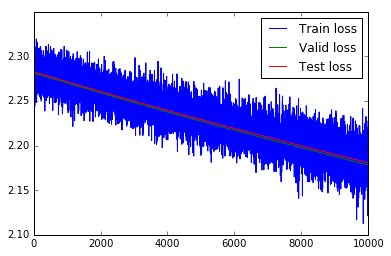

In [5]:
# # Display the learning curve and losses for training, validation, and testing
# %matplotlib inline
# %config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt

plt.plot(nn.losses['train'], label='Train loss')
plt.plot(nn.losses['valid'], label='Valid loss')
plt.plot(nn.losses['test'], label='Test loss')
plt.legend()
plt.show()

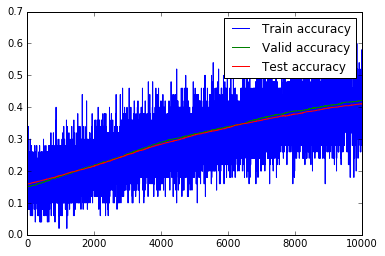

In [6]:
plt.plot(nn.losses['train_acc'], label='Train accuracy')
plt.plot(nn.losses['valid_acc'], label='Valid accuracy')
plt.plot(nn.losses['test_acc'], label='Test accuracy')
plt.legend()
plt.show()